<img src="data/photutils_banner.svg" width=500 alt="Photutils logo">

# Photutils

- Code: https://github.com/astropy/photutils
- Documentation: https://photutils.readthedocs.io/en/stable/
- Issue Tracker:  https://github.com/astropy/photutils/issues

## Photutils capabilities:

- Background and background noise estimation
- Source Detection and Extraction
  - DAOFIND and IRAF's starfind
  - Image segmentation
  - local peak finder
- Aperture photometry
- PSF photometry
- ePSF building
- PSF matching
- Centroids
- Morphological properties
- Elliptical isophote analysis


## In this additional notebook, we will review:

- Aperture photometry (repeat of photutils overview material)
- Using image segmentation to generate elliptical apertures of extended sources

## Preliminaries

In [5]:
# initial imports
import numpy as np
import matplotlib.pyplot as plt

# change some default plotting parameters
import matplotlib as mpl
mpl.rcParams['image.origin'] = 'lower'
mpl.rcParams['image.interpolation'] = 'nearest'

# Run the %matplotlib magic command to enable inline plotting
# in the current notebook.  Choose one of these:
%matplotlib inline
# %matplotlib notebook

### Load the data

We'll start by reading data and error arrays from FITS files.  These are cutouts from the HST Extreme-Deep Field (XDF) taken with WFC3/IR in the F160W filter.

In [6]:
from astropy.io import fits
sci_fn = 'data/xdf_hst_wfc3ir_60mas_f160w_sci.fits'
rms_fn = 'data/xdf_hst_wfc3ir_60mas_f160w_rms.fits'
sci_hdulist = fits.open(sci_fn)
rms_hdulist = fits.open(rms_fn)

sci_hdulist[0].header['BUNIT'] = 'electron/s'

Print some info about the data.

In [7]:
sci_hdulist.info()

Filename: data/xdf_hst_wfc3ir_60mas_f160w_sci.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      42   (200, 200)   float32   


Define the data and error arrays.

In [8]:
data = sci_hdulist[0].data.astype(np.float)
error = rms_hdulist[0].data.astype(np.float)

Extract the data header and create a WCS object.

In [9]:
from astropy.wcs import WCS

hdr = sci_hdulist[0].header
wcs = WCS(hdr)

Display the data.

In [10]:
from astropy.visualization import simple_norm

Text(0.5, 1.0, 'XDF F160W Cutout')

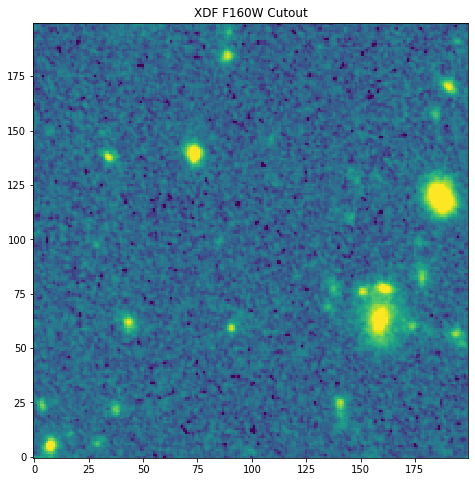

In [11]:
plt.figure(figsize=(8, 8))
norm = simple_norm(data, 'sqrt', percent=99.)
plt.imshow(data, norm=norm)
plt.title('XDF F160W Cutout')

---
# Part 1:  Aperture Photometry

## Performing aperture photometry at multiple positions

In [12]:
import astropy.units as u
from photutils.utils import calc_total_error
from photutils import CircularAperture, aperture_photometry

positions = [(90.73, 59.43), (73.63, 139.41), (43.62, 61.63)]
radius = 5.
apertures = CircularAperture(positions, r=radius)

eff_gain = hdr['TEXPTIME']
tot_error = calc_total_error(data, error, eff_gain)

unit = u.electron / u.s

phot = aperture_photometry(data * unit, apertures, error=tot_error * unit)
phot

id,xcenter,ycenter,aperture_sum,aperture_sum_err
,pix,pix,electron / s,electron / s
int64,float64,float64,float64,float64
1,90.73,59.43,0.12039154582527045,0.008044023150701417
2,73.63,139.41,0.6150243632978061,0.00816628074162013
3,43.62,61.63,0.21352615994892402,0.008069761430877863


## Bad pixel masking

In [13]:
# create a bad pixel
data2 = data.copy()
y, x = 59, 91
data2[y, x] = 100.

aperture_photometry(data2, apertures, error=tot_error)

id,xcenter,ycenter,aperture_sum,aperture_sum_err
,pix,pix,,
int64,float64,float64,float64,float64
1,90.73,59.43,100.11319073802662,0.008044023150701417
2,73.63,139.41,0.6150243632978061,0.00816628074162013
3,43.62,61.63,0.21352615994892402,0.008069761430877863


Note the large `aperture_sum` in the first source due to the bad pixel.  Now mask the bad pixel so that it does not contribute to the photometry.

In [14]:
mask = np.zeros_like(data2, dtype=bool)
mask[y, x] = True

aperture_photometry(data2, apertures, error=tot_error, mask=mask)

id,xcenter,ycenter,aperture_sum,aperture_sum_err
,pix,pix,,
int64,float64,float64,float64,float64
1,90.73,59.43,0.11319073802661661,0.007991749523793938
2,73.63,139.41,0.6150243632978061,0.00816628074162013
3,43.62,61.63,0.21352615994892402,0.008069761430877863


## Performing aperture photometry at multiple positions using multiple apertures

First define three different aperture shapes (different radii), but with the same positions.

In [15]:
positions = [(90.73, 59.43), (73.63, 139.41), (43.62, 61.63)]
radii = [5., 7.5, 9., 11.]
apertures = [CircularAperture(positions, r=r) for r in radii]

In [20]:
apertures

[<CircularAperture([[ 90.73,  59.43],
                    [ 73.63, 139.41],
                    [ 43.62,  61.63]], r=5.0)>,
 <CircularAperture([[ 90.73,  59.43],
                    [ 73.63, 139.41],
                    [ 43.62,  61.63]], r=7.5)>,
 <CircularAperture([[ 90.73,  59.43],
                    [ 73.63, 139.41],
                    [ 43.62,  61.63]], r=9.0)>,
 <CircularAperture([[ 90.73,  59.43],
                    [ 73.63, 139.41],
                    [ 43.62,  61.63]], r=11.0)>]

In [26]:
apertures[2][1]  # the aperture for the third radius and second position

<CircularAperture([ 73.63, 139.41], r=9.0)>

In [30]:
phot = aperture_photometry(data * unit, apertures, error=tot_error * unit)
phot

id,xcenter,ycenter,aperture_sum_0,aperture_sum_err_0,aperture_sum_1,aperture_sum_err_1,aperture_sum_2,aperture_sum_err_2,aperture_sum_3,aperture_sum_err_3
,pix,pix,electron / s,electron / s,electron / s,electron / s,electron / s,electron / s,electron / s,electron / s
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1,90.73,59.43,0.12039154582527045,0.008044023150701417,0.1393681049395568,0.01204875328039566,0.1567233443389367,0.01445528321856259,0.1849595602145676,0.017658184899138073
2,73.63,139.41,0.6150243632978061,0.00816628074162013,0.7335947208192003,0.012172550968591505,0.7584450135659184,0.014587065263802693,0.7850145516886573,0.017807733526686798
3,43.62,61.63,0.21352615994892402,0.008069761430877863,0.26397917122319403,0.012092275127651105,0.27379087888794956,0.014495639780282177,0.2740932474086888,0.01770451932437249


The output table above now contains columns for the `aperture_sum` and `aperture_sum_err` for each aperture.  The column names are appended with `_N`, where N is running index of the apertures in the input `apertures` list, i.e. the first aperture is `_0`, the second is `_1`, etc.

We can add columns to the table indicating the aperture radii.

In [28]:
phot['aperture_radius_0'] = np.ones(len(phot)) * radii[0] * u.pix
phot['aperture_radius_1'] = np.ones(len(phot)) * radii[1] * u.pix
phot['aperture_radius_2'] = np.ones(len(phot)) * radii[2] * u.pix
phot['aperture_radius_3'] = np.ones(len(phot)) * radii[3] * u.pix
phot

# # A more concise way to accomplish the same thing, useful for adding many new aperture radii to the table
# for i, rad in enumerate(radii):
#     phot['aperture_radius_{}'.format(i)] = np.ones(len(phot)) * radii[0] * u.pix

id,xcenter,ycenter,aperture_sum_0,aperture_sum_err_0,aperture_sum_1,aperture_sum_err_1,aperture_sum_2,aperture_sum_err_2,aperture_sum_3,aperture_sum_err_3,aperture_radius_0,aperture_radius_1,aperture_radius_2,aperture_radius_3
,pix,pix,electron / s,electron / s,electron / s,electron / s,electron / s,electron / s,electron / s,electron / s,pix,pix,pix,pix
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1,90.73,59.43,0.12039154582527045,0.008044023150701417,0.1393681049395568,0.01204875328039566,0.1567233443389367,0.01445528321856259,0.1849595602145676,0.017658184899138073,5.0,7.5,9.0,11.0
2,73.63,139.41,0.6150243632978061,0.00816628074162013,0.7335947208192003,0.012172550968591505,0.7584450135659184,0.014587065263802693,0.7850145516886573,0.017807733526686798,5.0,7.5,9.0,11.0
3,43.62,61.63,0.21352615994892402,0.008069761430877863,0.26397917122319403,0.012092275127651105,0.27379087888794956,0.014495639780282177,0.2740932474086888,0.01770451932437249,5.0,7.5,9.0,11.0


and put them in the table metadata:

In [34]:
for i in range(len(radii)):
    phot.meta['aperture_{}'.format(i)] = 'Circular aperture with r={} pix'.format(radii[i])

In [35]:
phot.meta

OrderedDict([('name', 'Aperture photometry results'),
             ('version', 'astropy: 3.2.3, photutils: 0.7.1'),
             ('aperture_photometry_args', "method='exact', subpixels=5"),
             ('aperture_0', 'Circular aperture with r=5.0 pix'),
             ('aperture_1', 'Circular aperture with r=7.5 pix'),
             ('aperture_2', 'Circular aperture with r=9.0 pix'),
             ('aperture_3', 'Circular aperture with r=11.0 pix')])

## Aperture photometry using Sky apertures

First, let's define the sky coordinates by converting our pixel coordinates.

In [41]:
positions = [(90.73, 59.43), (73.63, 139.41), (43.62, 61.63)]
x, y = np.transpose(positions) # transform coordinate pairs to a list of x and a list of y coordinates
coord = wcs.pixel_to_world(x, y)
coord

<SkyCoord (FK5: equinox=2000.0): (ra, dec) in deg
    [(53.1588915 , -27.76500214), (53.15921314, -27.76366906),
     (53.15977882, -27.76496524)]>

Now define a circular aperture in sky coordinates.

For sky apertures in angular units, the aperture radius must be a `Quantity`, in either pixel or angular units.

In [42]:
from photutils import SkyCircularAperture

radius = 5. * u.pix
sky_apers = SkyCircularAperture(coord, r=radius)
sky_apers.r

<Quantity 5. pix>

In [43]:
radius = 0.5 * u.arcsec
sky_apers = SkyCircularAperture(coord, r=radius)
sky_apers.r

<Quantity 0.5 arcsec>

When using a sky aperture in angular units, `aperture_photometry` needs the WCS transformation, which can be input via the `wcs` keyword:

In [44]:
phot = aperture_photometry(data, sky_apers, wcs=wcs)
phot

id,xcenter,ycenter,sky_center,aperture_sum
,pix,pix,"deg,deg",
int64,float64,float64,object,float64
1,90.73000000001593,59.430000000468226,"53.158891500867604,-27.765002141410175",0.14686106763789314
2,73.63000000060538,139.40999999953056,"53.15921313626186,-27.763669058236427",0.7507009236808948
3,43.620000000119944,61.63000000022339,"53.159778816470286,-27.764965241221894",0.2695146575990177


## Encircled flux

Here we want to perform aperture photometry at a single position with *many* apertures.

Instead of generating a big table, we'll simply loop over the apertures and extract the fluxes from individual tables.

In [ ]:
radii = np.linspace(0.1, 20, 100)  # 100 apertures
flux = []
for r in radii:
    ap = CircularAperture(positions[1], r=r)  # single position
    phot = aperture_photometry(data, ap)
    flux.append(phot['aperture_sum'][0])

In [ ]:
plt.plot(radii, flux, '+-')
plt.title('Encircled Flux')
plt.xlabel('Radius (pixels)')
plt.ylabel('Aperture Sum ($e^{-1}/s$)');

## More about apertures:  Advanced usage

### Aperture masks

In [ ]:
positions = [(90.73, 59.43), (73.63, 139.41), (43.62, 61.63)]
radius = 5.
apertures = CircularAperture(positions, r=radius)

Create a list of `ApertureMask` objects using the `to_mask()` method.

In [ ]:
masks = apertures.to_mask(method='exact')

Let's plot the first one.

In [ ]:
mask = masks[0]  # the first one
plt.imshow(mask)
plt.colorbar()

The above image is a cutout of the aperture mask.

We can create an image with the aperture mask at its position.

In [ ]:
img = mask.to_image(shape=((200, 200)))
plt.imshow(img)
plt.colorbar()

We can also create a cutout from a data image over the mask domain.

In [ ]:
data_cutout = mask.cutout(data)
plt.imshow(data_cutout)
plt.colorbar()

We can also create a mask-weighted cutout from the data.  Here the circular aperture mask has been applied to the data.

In [ ]:
data_cutout_aper = mask.multiply(data)
plt.imshow(data_cutout_aper)
plt.colorbar()

---
# Part 2:  Image Segmentation (extended version)

Image segmentation is the process where sources are identified and labeled in an image.

The sources are detected by using a S/N threshold level and defining the minimum number of pixels required within a source.

First, let's define a threshold image at 2$\sigma$ (per pixel) above the background.

In [ ]:
bkg = 0.  # background level in this image
nsigma = 2.
threshold = bkg + (nsigma * error)  # this should be background-only error

Now let's detect "8-connected" sources of minimum size 5 pixels where each pixel is 2$\sigma$ above the background.

"8-connected" pixels touch along their edges or corners. "4-connected" pixels touch along their edges. For reference, SExtractor uses "8-connected" pixels.

The result is a segmentation image (`SegmentationImage` object).  The segmentation image is the isophotal footprint of each source above the threshold.

In [ ]:
from photutils import detect_sources

npixels = 5
segm = detect_sources(data, threshold, npixels)

print('Found {0} sources'.format(segm.nlabels))

Display the segmentation image.

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 10))
ax1.imshow(data, norm=norm)
lbl1 = ax1.set_title('Data')
ax2.imshow(segm, cmap=segm.make_cmap())
lbl2 = ax2.set_title('Segmentation Image')

It is better to filter (smooth) the data prior to source detection.

Let's use a 5x5 Gaussian kernel with a FWHM of 2 pixels.

In [ ]:
from astropy.convolution import Gaussian2DKernel
from astropy.stats import gaussian_fwhm_to_sigma

sigma = 2.0 * gaussian_fwhm_to_sigma  # FWHM = 2 pixels
kernel = Gaussian2DKernel(sigma, x_size=5, y_size=5)
kernel.normalize()

ssegm = detect_sources(data, threshold, npixels, filter_kernel=kernel)
print('Found {0} sources'.format(ssegm.nlabels))

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 10))
ax1.imshow(segm, cmap=segm.make_cmap())
lbl1 = ax1.set_title('Original Data Segmentation')
ax2.imshow(ssegm, cmap=ssegm.make_cmap())
lbl2 = ax2.set_title('Smoothed Data Segmentation')

### Source deblending

Note above that some of our detected sources were blended.  We can deblend them using the `deblend_sources()` function, which uses a combination of multi-thresholding and watershed segmentation.

In [ ]:
from photutils import deblend_sources

segm2 = deblend_sources(data, ssegm, npixels, filter_kernel=kernel,
                        contrast=0.001, nlevels=32)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 8))
ax1.imshow(data, norm=norm)
ax1.set_title('Data')
ax2.imshow(ssegm, cmap=ssegm.make_cmap())
ax2.set_title('Original Segmentation Image')
ax3.imshow(segm2, cmap=segm2.make_cmap())
ax3.set_title('Deblended Segmentation Image')

print('Found {0} sources'.format(segm2.nlabels))

## Measure the photometry and morphological properties of detected sources

In [ ]:
from photutils import source_properties
catalog = source_properties(data, segm2, error=error, wcs=wcs)

`catalog` is a `SourceCatalog` object.  It behaves like a list of `SourceProperties` objects, one for each source.

In [ ]:
catalog

In [ ]:
catalog[0]  # the first source

In [ ]:
catalog[0].xcentroid  # the xcentroid of the first source

Please go [here](http://photutils.readthedocs.io/en/latest/api/photutils.segmentation.SourceProperties.html#photutils.segmentation.SourceProperties) to see the complete list of available source properties.

We can create a Table of isophotal photometry and morphological properties using the ``to_table()`` method of `SourceCatalog`:

In [ ]:
tbl = catalog.to_table()
tbl

A subset of source can be specified, defined by the their labels in the segmentation image.

In [ ]:
labels = [1, 5, 7, 12]
cat2 = source_properties(data, segm, error=error, wcs=wcs, labels=labels)
tbl2 = cat2.to_table()
tbl2

A subset of property columns can also be specified.

In [ ]:
columns = ['id', 'xcentroid', 'ycentroid', 'source_sum', 'area']
tbl3 = catalog.to_table(columns=columns)
tbl3

or a subset of sources with a subset of properties:

In [ ]:
tbl4 = cat2.to_table(columns=columns)
tbl4

Additional properties (not stored in the table) can be accessed directly via the `SourceCatalog` object.

In [ ]:
# get a single object (id=12)
obj = catalog[11]
obj.id

In [ ]:
obj

Let's plot the cutouts of the data and error images for this source.

In [ ]:
fig, ax = plt.subplots(figsize=(12, 8), ncols=3)
ax[0].imshow(obj.make_cutout(segm2.data))
ax[0].set_title('Source id={} Segment'.format(obj.id))
ax[1].imshow(obj.data_cutout_ma)
ax[1].set_title('Source id={} Data'.format(obj.id))
ax[2].imshow(obj.error_cutout_ma)
ax[2].set_title('Source id={} Error'.format(obj.id));

## Define the approximate isophotal ellipses for each object

Create elliptical apertures for each object using the measured morphological parameters.

In [ ]:
from photutils import EllipticalAperture

r = 3.  # approximate isophotal extent
apertures = []
for obj in catalog:
    position = (obj.xcentroid.value, obj.ycentroid.value)
    a = obj.semimajor_axis_sigma.value * r
    b = obj.semiminor_axis_sigma.value * r
    theta = obj.orientation.value
    apertures.append(EllipticalAperture(position, a, b, theta=theta))

Now plot the elliptical apertures on the data and the segmentation image.

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 10))
ax1.imshow(data, norm=norm)
ax1.set_title('Data')
ax2.imshow(segm2, cmap=segm2.make_cmap())
ax2.set_title('Segmentation Image')
for aperture in apertures:
    aperture.plot(color='white', lw=1.5, alpha=0.8, axes=ax1)
    aperture.plot(color='white', lw=1.5, alpha=1.0, axes=ax2)

_Note that the segmentation image can be reused on other registered data (e.g., multiple filters) to generate a multiband catalog.  One does not need to regenerate it each time -- simply apply it to other bands and/or data._

The segmentation image can also be modified before measuring source photometry/properties, e.g.:

 - remove source segments (artifacts, diffraction spikes, etc.)
 - combine segments
 - mask regions of a segmentation image (e.g. near image borders)

See [modifying segmentation images](https://photutils.readthedocs.io/en/stable/segmentation.html#modifying-a-segmentation-image) for further information.

If desired, a `SExtractor` segmentation image can even be input to Photutils `source_properties()`.

To generate a `SExtractor` segmentation image, set the following in the SExtractor config:
```
CHECKIMAGE_TYPE   SEGMENTATION
CHECKIMAGE_NAME   segmentation.fits
```

Once `segmentation.fits` exists, one could do the following:

`>>> from photutils import SegmentationImage`

`>>> se_segm_data = fits.getdata('segmentation_fits')`

`>>> se_segm = SegmentationImage(se_segm_data)`

`>>> se_cat = source_properties(data, se_segm, error=error, wcs=wcs, labels=labels)`

Note that `data` and `se_segm_data` must have the same shape and be registered.